In [1]:
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Camera Calibration
===

In [2]:
# Create object points.
objp = np.zeros((9 * 6, 3), np.float32)
objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

# Lists to store object points and images points.
objpoints = [] # 3d points in real space.
imgpoints = [] # 2d points in image plane.

# Make a list of all images paths.
images = glob.glob('camera_cal/*.jpg')

# Cycle through each image to find corners points.
for fname in images:
    # Read image.
    img = cv2.imread(fname)
    # Graysclae.
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Find chessboard corners.
    ret, corners = cv2.findChessboardCorners(gray, (9, 6))
    
    # If corners are detected.
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # Draw images with detected corners.
        cv2.drawChessboardCorners(img, (9, 6), corners, ret)
        cv2.imshow('img', img)
        cv2.waitKey(250)
        
cv2.destroyAllWindows()

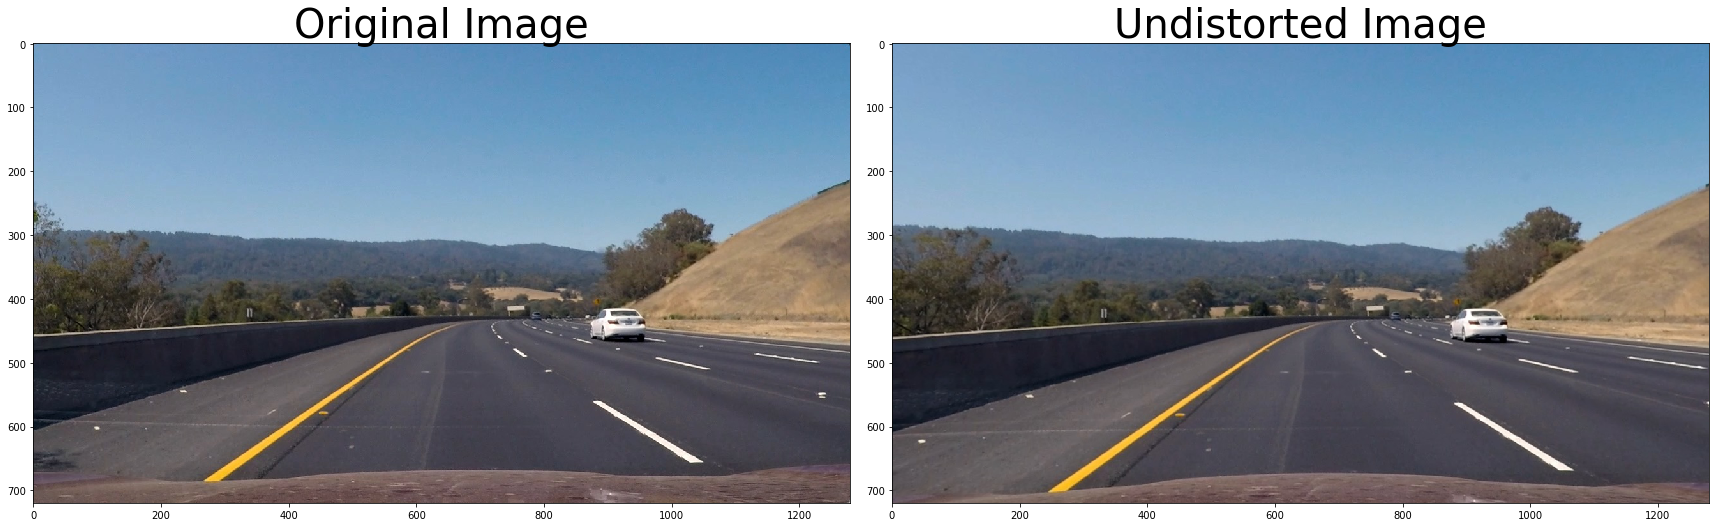

In [303]:
# Define a function to calibrate camera and undistort images.
def cal_undistort(img, objpoints, imgpoints): # img has to be of the same shape as the chessboard images??
    ret, intrmtx, distcoeff, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undistorted = cv2.undistort(img, intrmtx, distcoeff)
    return undistorted

# Test cal_undistort function.
img = mpimg.imread('test_images/test3.jpg')
undistorted = cal_undistort(img, objpoints, imgpoints)

# Plot the original and the undistorted images side by side.
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=40)

Image Thresholding
===

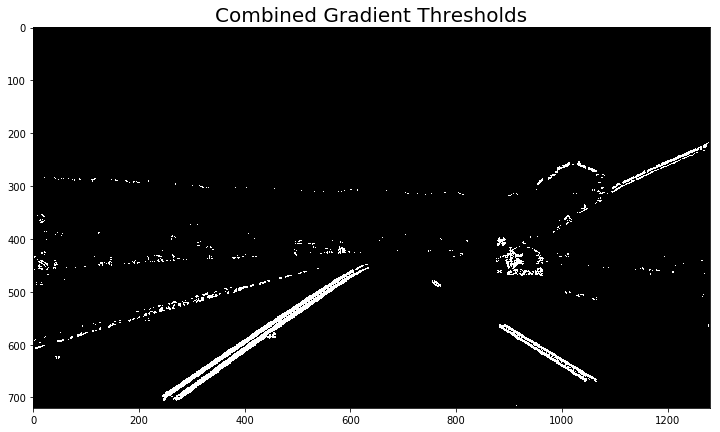

In [322]:
# Define a function to apply x or y gradient absolute value thresholds.   
def abs_thresh(img, orient='x', thresh=(20, 255), kernel=3):
    # Convert to HLS Colorspace.
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    # Separate saturation channel to apply the gradients on.
    sat = hls[:, :, 2]
    # Derive the gradient.
    if orient=='x':
        grad = cv2.Sobel(sat, cv2.CV_64F, 1, 0, ksize=kernel)
    elif orient=='y':
        grad = cv2.Sobel(sat, cv2.CV_64F, 0, 1, ksize=kernel)
    # Absolute value.
    abs = np.absolute(grad)
    # Scale the output to a (0 to 255) 8-bit single channel image.
    scaled = np.uint8(abs / np.amax(abs) * 255)
    # Apply thresholds.
    binary = np.zeros_like(scaled)
    binary[(scaled >= thresh[0]) & (scaled <= thresh[1])] = 1
    return binary

# Define a function to apply gradient magnitude thresholds.  
def mag_thresh(img, thresh=(20, 255), kernel=3):
    # Convert to HLS Colorspace.
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    # Separate saturation channel to apply the gradients on.
    sat = hls[:, :, 2]
    # Derive the gradients.
    xgrad = cv2.Sobel(sat, cv2.CV_64F, 1, 0, ksize=kernel)
    ygrad = cv2.Sobel(sat, cv2.CV_64F, 0, 1, ksize=kernel)
    # Calculate magnitude.
    mag = (xgrad ** 2 + ygrad ** 2) ** 0.5
    # Scale the output to a (0 to 255) 8-bit single channel image.
    scaled = np.uint8(mag / np.amax(mag) * 255)
    # Apply thresholds.
    binary = np.zeros_like(scaled)
    binary[(scaled >= thresh[0]) & (scaled <= thresh[1])] = 1
    return binary

# Define a function to apply gradient direction thresholds.
def dir_thresh(img, thresh=(0.85, 1.1), kernel=3):
    # Convert to HLS Colorspace.
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    # Separate saturation channel to apply the gradients on.
    sat = hls[:, :, 2]
    # Derive the gradients.
    xgrad = cv2.Sobel(sat, cv2.CV_64F, 1, 0, ksize=kernel)
    ygrad = cv2.Sobel(sat, cv2.CV_64F, 0, 1, ksize=kernel)
    # Absolute values.
    xabs = np.absolute(xgrad)
    yabs = np.absolute(ygrad)
    # Calculate angles in radians.
    radian = np.arctan2(yabs, xabs)
    # Apply thresholds.
    binary = np.zeros_like(sat)
    binary[(radian >= thresh[0]) & (radian <= thresh[1])] = 1
    return binary
    
# Test the gradient thresholding functions.
gradx_binary = abs_thresh(undistorted, orient='x', thresh=(20, 255), kernel=9)
grady_binary = abs_thresh(undistorted, orient='y', thresh=(20, 255), kernel=9)
mag_binary = mag_thresh(undistorted, thresh=(30, 255), kernel=9)
dir_binary = dir_thresh(undistorted, thresh=(0.80, 1.3), kernel=9)
  
# Combine information from all the gradient binary images.
gradcombined = np.zeros_like(gradx_binary)
gradcombined[((gradx_binary == 1) & (grady_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

# Plot gradient combined binary image.
plt.figure(figsize=(14,7))
plt.imshow(gradcombined, cmap='gray')
plt.title('Combined Gradient Thresholds', fontsize=20)

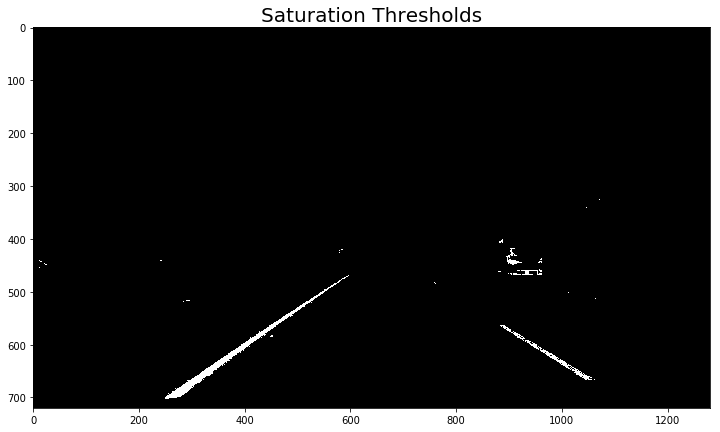

In [323]:
# Define a function to apply saturation thresholds.   
def sat_thresh(img, thresh=(50, 255)):
    # Convert to HLS Colorspace.
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    # Separate saturation channel to apply the gradients on.
    sat = hls[:, :, 2]
    # Apply thresholds.
    binary = np.zeros_like(sat)
    binary[(sat >= thresh[0]) & (sat <= thresh[1])] = 1
    return binary

# Test the saturation thresholding function.
sat_binary = sat_thresh(undistorted, thresh=(150, 255))

# Plot saturation binary image.
plt.figure(figsize=(14,7))
plt.imshow(sat_binary, cmap='gray')
plt.title('Saturation Thresholds', fontsize=20)

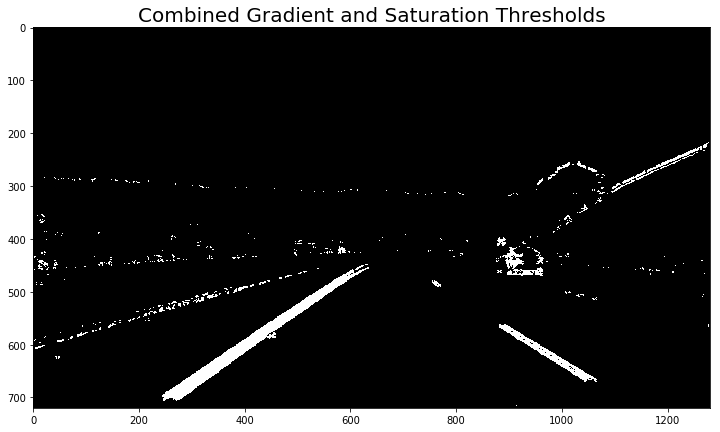

In [330]:
# Combine information from both the saturation binary image and the combined gradient binary image.
combined = np.zeros_like(gradcombined)
combined[(gradcombined == 1) | (sat_binary == 1)] = 1

# Plot combined binary image.
plt.figure(figsize=(14,7))
plt.imshow(combined, cmap='gray')
plt.title('Combined Gradient and Saturation Thresholds', fontsize=20)

Image Masking
===

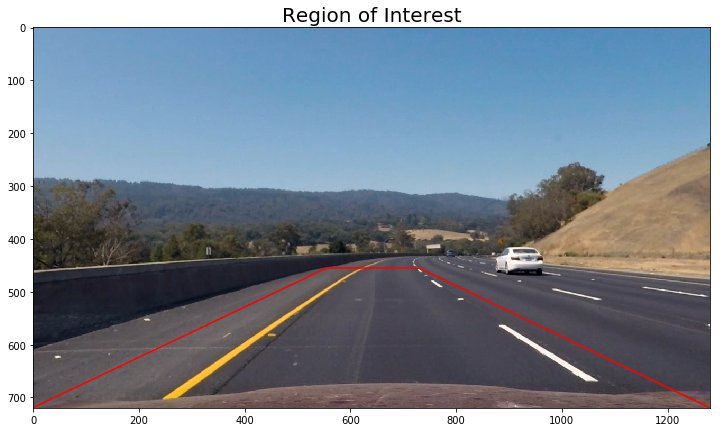

In [325]:
# Define region of interest points.
region = np.int32([[[0, 719],
                  [555, 455],
                  [730, 455],
                  [1279, 719]]])

# Plot selected destination points.
plt.figure(figsize=(14,7))
plt.imshow(undistorted)
plt.plot(region.T[0], region.T[1], 'r')
plt.title('Region of Interest', fontsize=20)

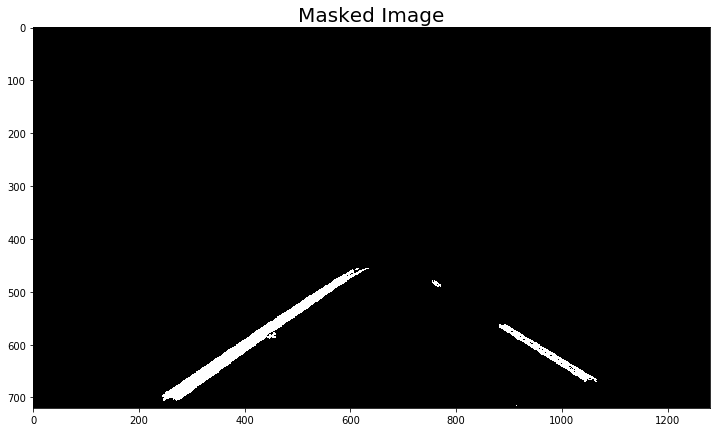

In [326]:
# Apply a mask to delete portions of the image outside the region of interest.
mask = np.zeros_like(combined)
cv2.fillPoly(mask, region, 255) # Fill the region of interest with maximum value.
masked_image = cv2.bitwise_and(combined, mask)

# Plot masked image.
plt.figure(figsize=(14,7))
plt.imshow(masked_image, cmap='gray')
plt.title('Masked Image', fontsize=20)

Perspective Warping
===

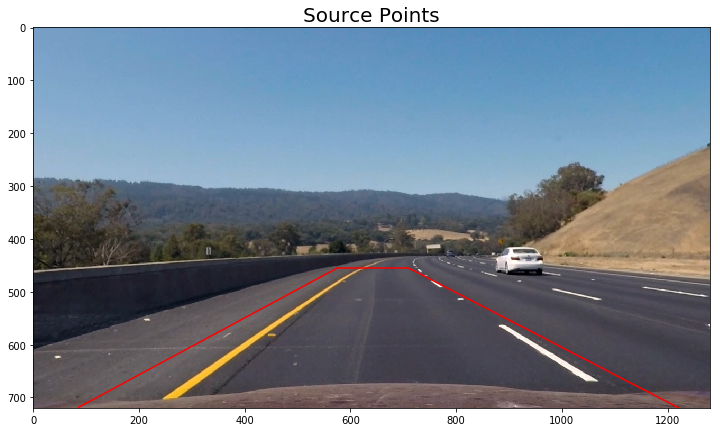

In [327]:
# Define source points for perspective warping.
src = np.float32([[85, 719],
                  [575, 455],
                  [710, 455],
                  [1220, 719]])

# Plot selected source points.
plt.figure(figsize=(14,7))
plt.imshow(undistorted)
plt.plot(src.T[0], src.T[1], 'r')
plt.title('Source Points', fontsize=20)

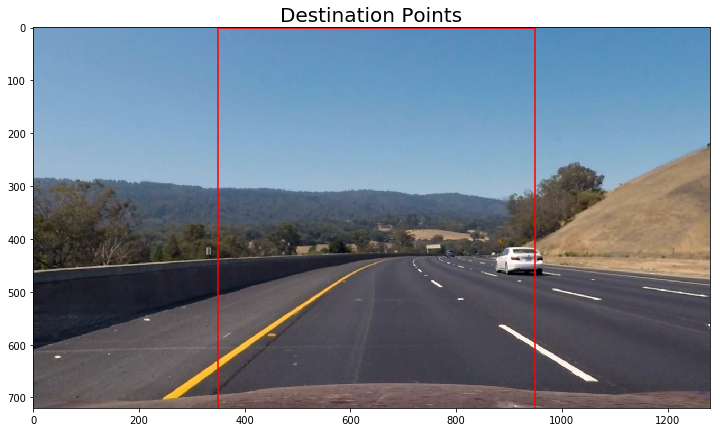

In [328]:
# Define destination points for perspective warping.
dst = np.float32([[350, 719],
                  [350, 0],
                  [950, 0],
                  [950, 719]])

# Plot selected destination points.
plt.figure(figsize=(14,7))
plt.imshow(undistorted)
plt.plot(dst.T[0], dst.T[1], 'r')
plt.title('Destination Points', fontsize=20)

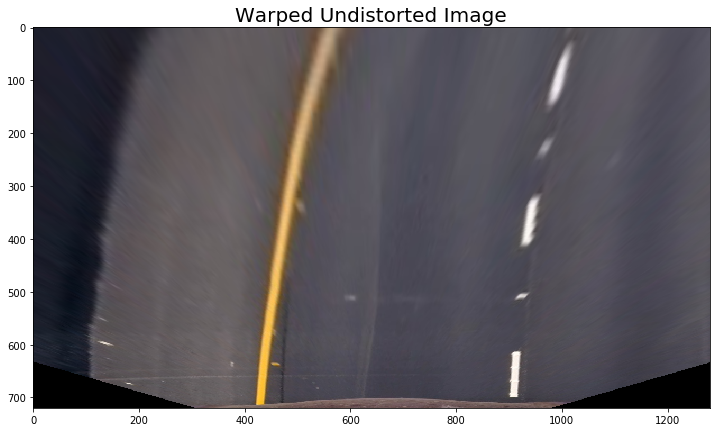

In [329]:
# Define a function to warp prespective to a bird's eye view.
def bird_eye(img, src, dst):
    # Compute the perspective transform matrix.
    M = cv2.getPerspectiveTransform(src, dst)
    # Compute the inverse transform matrix.
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp image.
    warped = cv2.warpPerspective(img, M, img.shape[1::-1], flags=cv2.INTER_LINEAR)
    return warped

# Test the bird's eye view function on the undistorted image
warped = bird_eye(undistorted, src, dst)

# Plot the bird's eye view image.
plt.figure(figsize=(14,7))
plt.imshow(warped, cmap='gray')
plt.title('Warped Undistorted Image', fontsize=20)

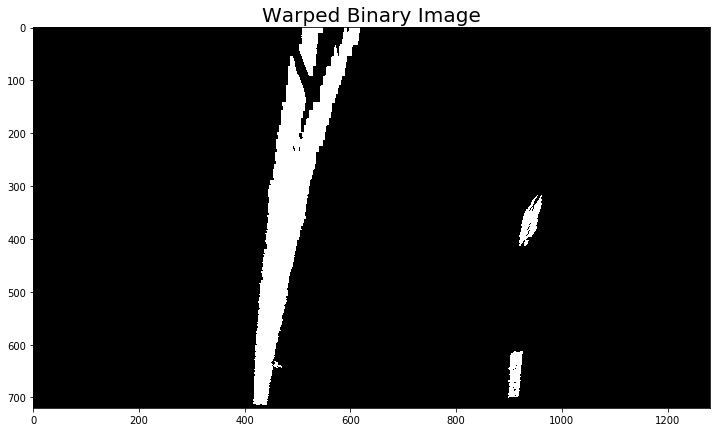

In [332]:
# Test the bird's eye view function on the masked image.
warped = bird_eye(masked_image, src, dst)

# Plot the bird's eye view image.
plt.figure(figsize=(14,7))
plt.imshow(warped, cmap='gray')
plt.title('Warped Binary Image', fontsize=20)

Finding Lane Lines
===

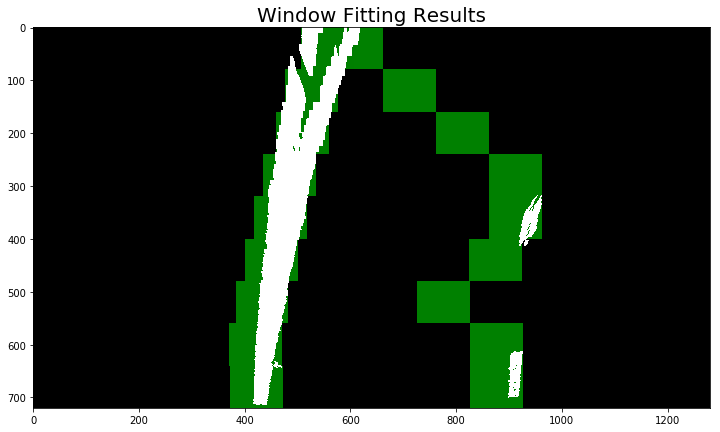

In [333]:
# Window settings.
window_width = 100 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

# Define a function to mask a window of given size and position.
def window_mask(width, height, img, center, level):
    output = np.zeros_like(img)
    output[int(img.shape[0] - (level + 1) * height):int(img.shape[0] - level * height), max(0, int(center - width / 2)):min(int(center + width / 2), img.shape[1])] = 1
    return output

# Define a function to return the positions of the windows centers.
def find_window_centroids(image, window_width, window_height, margin):    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template.
    
    # Sum quarter bottom of image to get slice.
    l_sum = np.sum(image[int(3 * image.shape[0] / 4):, :int(image.shape[1] / 2)], axis=0)
    l_center = np.argmax(np.convolve(window, l_sum)) - window_width / 2
    r_sum = np.sum(image[int(3 * image.shape[0] / 4):, int(image.shape[1] / 2):], axis=0)
    r_center = np.argmax(np.convolve(window, r_sum)) - window_width / 2 + int(image.shape[1] / 2)
    
    # Add what we found for the first layer.
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations.
    for level in range(1, int(image.shape[0] / window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0] - (level + 1) * window_height):int(image.shape[0] - level * window_height), :], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width / 2
        l_min_index = int(max(l_center + offset - margin, 0))
        l_max_index = int(min(l_center + offset + margin, image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index]) + l_min_index - offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center + offset - margin, 0))
        r_max_index = int(min(r_center + offset + margin, image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index]) + r_min_index - offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))
        
    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers.
if len(window_centroids) > 0:
    # Points used to draw all the left and right windows.
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows.
    for level in range(0,len(window_centroids)):
        l_mask = window_mask(window_width, window_height, warped, window_centroids[level][0], level)
        r_mask = window_mask(window_width, window_height, warped, window_centroids[level][1], level)
        # Add graphic points from window mask to total pixels found.
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points + l_points, np.uint8) # Add both left and right window pixels together.
    zero_channel = np.zeros_like(template) # Create a zero color channel.
    template = np.array(cv2.merge((zero_channel, template, zero_channel)), np.uint8) # Make window pixels green.
    warpage= np.dstack((warped, warped, warped)) * 255 # Making the original road pixels 3 color channels.
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # Overlay the orignal road image with window results.

# If no window centers found, just display orginal road image.
else:
    output = np.array(cv2.merge((warped, warped, warped)), np.uint8)

# Display the final results
plt.figure(figsize=(14,7))
plt.imshow(output)
plt.title('Window Fitting Results', fontsize=20)